Imports and other variables

In [102]:
import pandas as pd
import numpy as np
import os

Init dataframes

In [103]:

df = pd.read_csv(r'data/data_processed.csv')
df_continous = pd.read_csv(r'data/data_continous.csv')
df_categorical = pd.read_csv(r'data/data_categorical.csv')

# --------------------------------------------------------------------------------------------------
# copying job satisfaction into new array
JSat = df['JobSatisfaction'].values

# splitting inputs by row index
# continous data
df_training_continous = df_continous.iloc[:1400,:]
df_validation_continous = df_continous.iloc[1400:,:]
# categorical data
df_training_categorical = df_categorical.iloc[:1400,:]
df_validation_categorical = df_categorical.iloc[1400:,:]
# splitting outputs by number
JSat_training = JSat[:1400]
JSat_validation = JSat[1400:]
# --------------------------------------------------------------------------------------------------

Random forest classifier

In [104]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier

# continous data classifier
clf_continous = RandomForestClassifier(max_depth=None, random_state=None)

clf_continous.fit(df_training_continous,JSat_training)
acc_continous = clf_continous.score(df_validation_continous, JSat_validation)

# categorical data classifier
clf_categorical = RandomForestClassifier(max_depth=None, random_state=None)

clf_categorical.fit(df_training_categorical,JSat_training)
acc_categorical = clf_categorical.score(df_validation_categorical, JSat_validation)

Print results

In [105]:
# print results
print('Continous data accuracy: ', acc_continous)
print('Categorical data accuracy: ', acc_categorical)

# print(allColumnsNames)

Continous data accuracy:  0.32857142857142857
Categorical data accuracy:  1.0


Tensorflow

In [106]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers

# split data into training, validation and test
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

1176 training examples
147 validation examples
147 test examples


In [107]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  _df = dataframe.copy()
  target = _df.pop('JobSatisfaction')
  _df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(_df), target))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

ds_train = df_to_dataset(train, True, 5)

[(train_features, label_batch)] = ds_train.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of attrition:', train_features["Attrition"])
print('A batch of targets:', label_batch )

Every feature: ['Unnamed: 0', 'Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
A batch of attrition: tf.Tensor(
[[0]
 [0]
 [0]
 [0]
 [0]], shape=(5, 1), dtype=int64)
A batch of targets: tf.Tensor([3 3 2 4 4], shape=(5,), dtype=int64)


C:\Users\siman\AppData\Local\Temp\ipykernel_5468\1007012288.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  _df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [108]:

def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

monthly_rate_col = df["MonthlyRate"]
layer = get_normalization_layer('MonthlyRate', ds_train)
layer(monthly_rate_col)

<tf.Tensor: shape=(1, 1470), dtype=float32, numpy=
array([[ 0.11194454, -1.4711493 , -1.7461115 , ..., -0.79369605,
         0.6698305 ,  0.8439922 ]], dtype=float32)>

In [109]:

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

# test on dep
test_dep_col = df['Department']
test_dep_layer = get_category_encoding_layer(name='Department',
                                              dataset=ds_train,
                                              dtype='int64')
print(test_dep_layer(test_dep_col))

# test on education
test_education_col = df['Education']
test_dep_layer = get_category_encoding_layer(name='Education',
                                              dataset=ds_train,
                                              dtype='int64')
print(test_dep_layer(test_education_col))

tf.Tensor([0. 1. 1. 1.], shape=(4,), dtype=float32)
tf.Tensor([0. 1. 1. 1. 1. 1.], shape=(6,), dtype=float32)


In [110]:
batch_size = 1000

train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

# split categorical and continuous data
# # full data set
# header_continous = ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'PercentSalaryHike', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
# header_categorical = ['Attrition', 'BusinessTravel', 'Department', 'Education','EducationField','EnvironmentSatisfaction','Gender','JobInvolvement','JobLevel','JobRole','JobSatisfaction','MaritalStatus','NumCompaniesWorked', 'OverTime','PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel','TrainingTimesLastYear', 'WorkLifeBalance']
# optimized data
header_continous = ['Age', 'DailyRate', 'DistanceFromHome', 'MonthlyIncome', 'PercentSalaryHike', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
header_categorical = ['Attrition', 'BusinessTravel', 'Department', 'Education','EducationField','EnvironmentSatisfaction','Gender','JobInvolvement','JobLevel','JobRole','JobSatisfaction','MaritalStatus', 'OverTime','PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel','TrainingTimesLastYear', 'WorkLifeBalance']

C:\Users\siman\AppData\Local\Temp\ipykernel_5468\1007012288.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  _df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
C:\Users\siman\AppData\Local\Temp\ipykernel_5468\1007012288.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  _df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
C:\Users\siman\AppData\Local\Temp\ipykernel_5468\1007012288.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  _df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [111]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in header_continous:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [112]:
for header in header_categorical:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='int64',
                                               max_tokens=None)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

In [113]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(48, activation="sigmoid")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [114]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

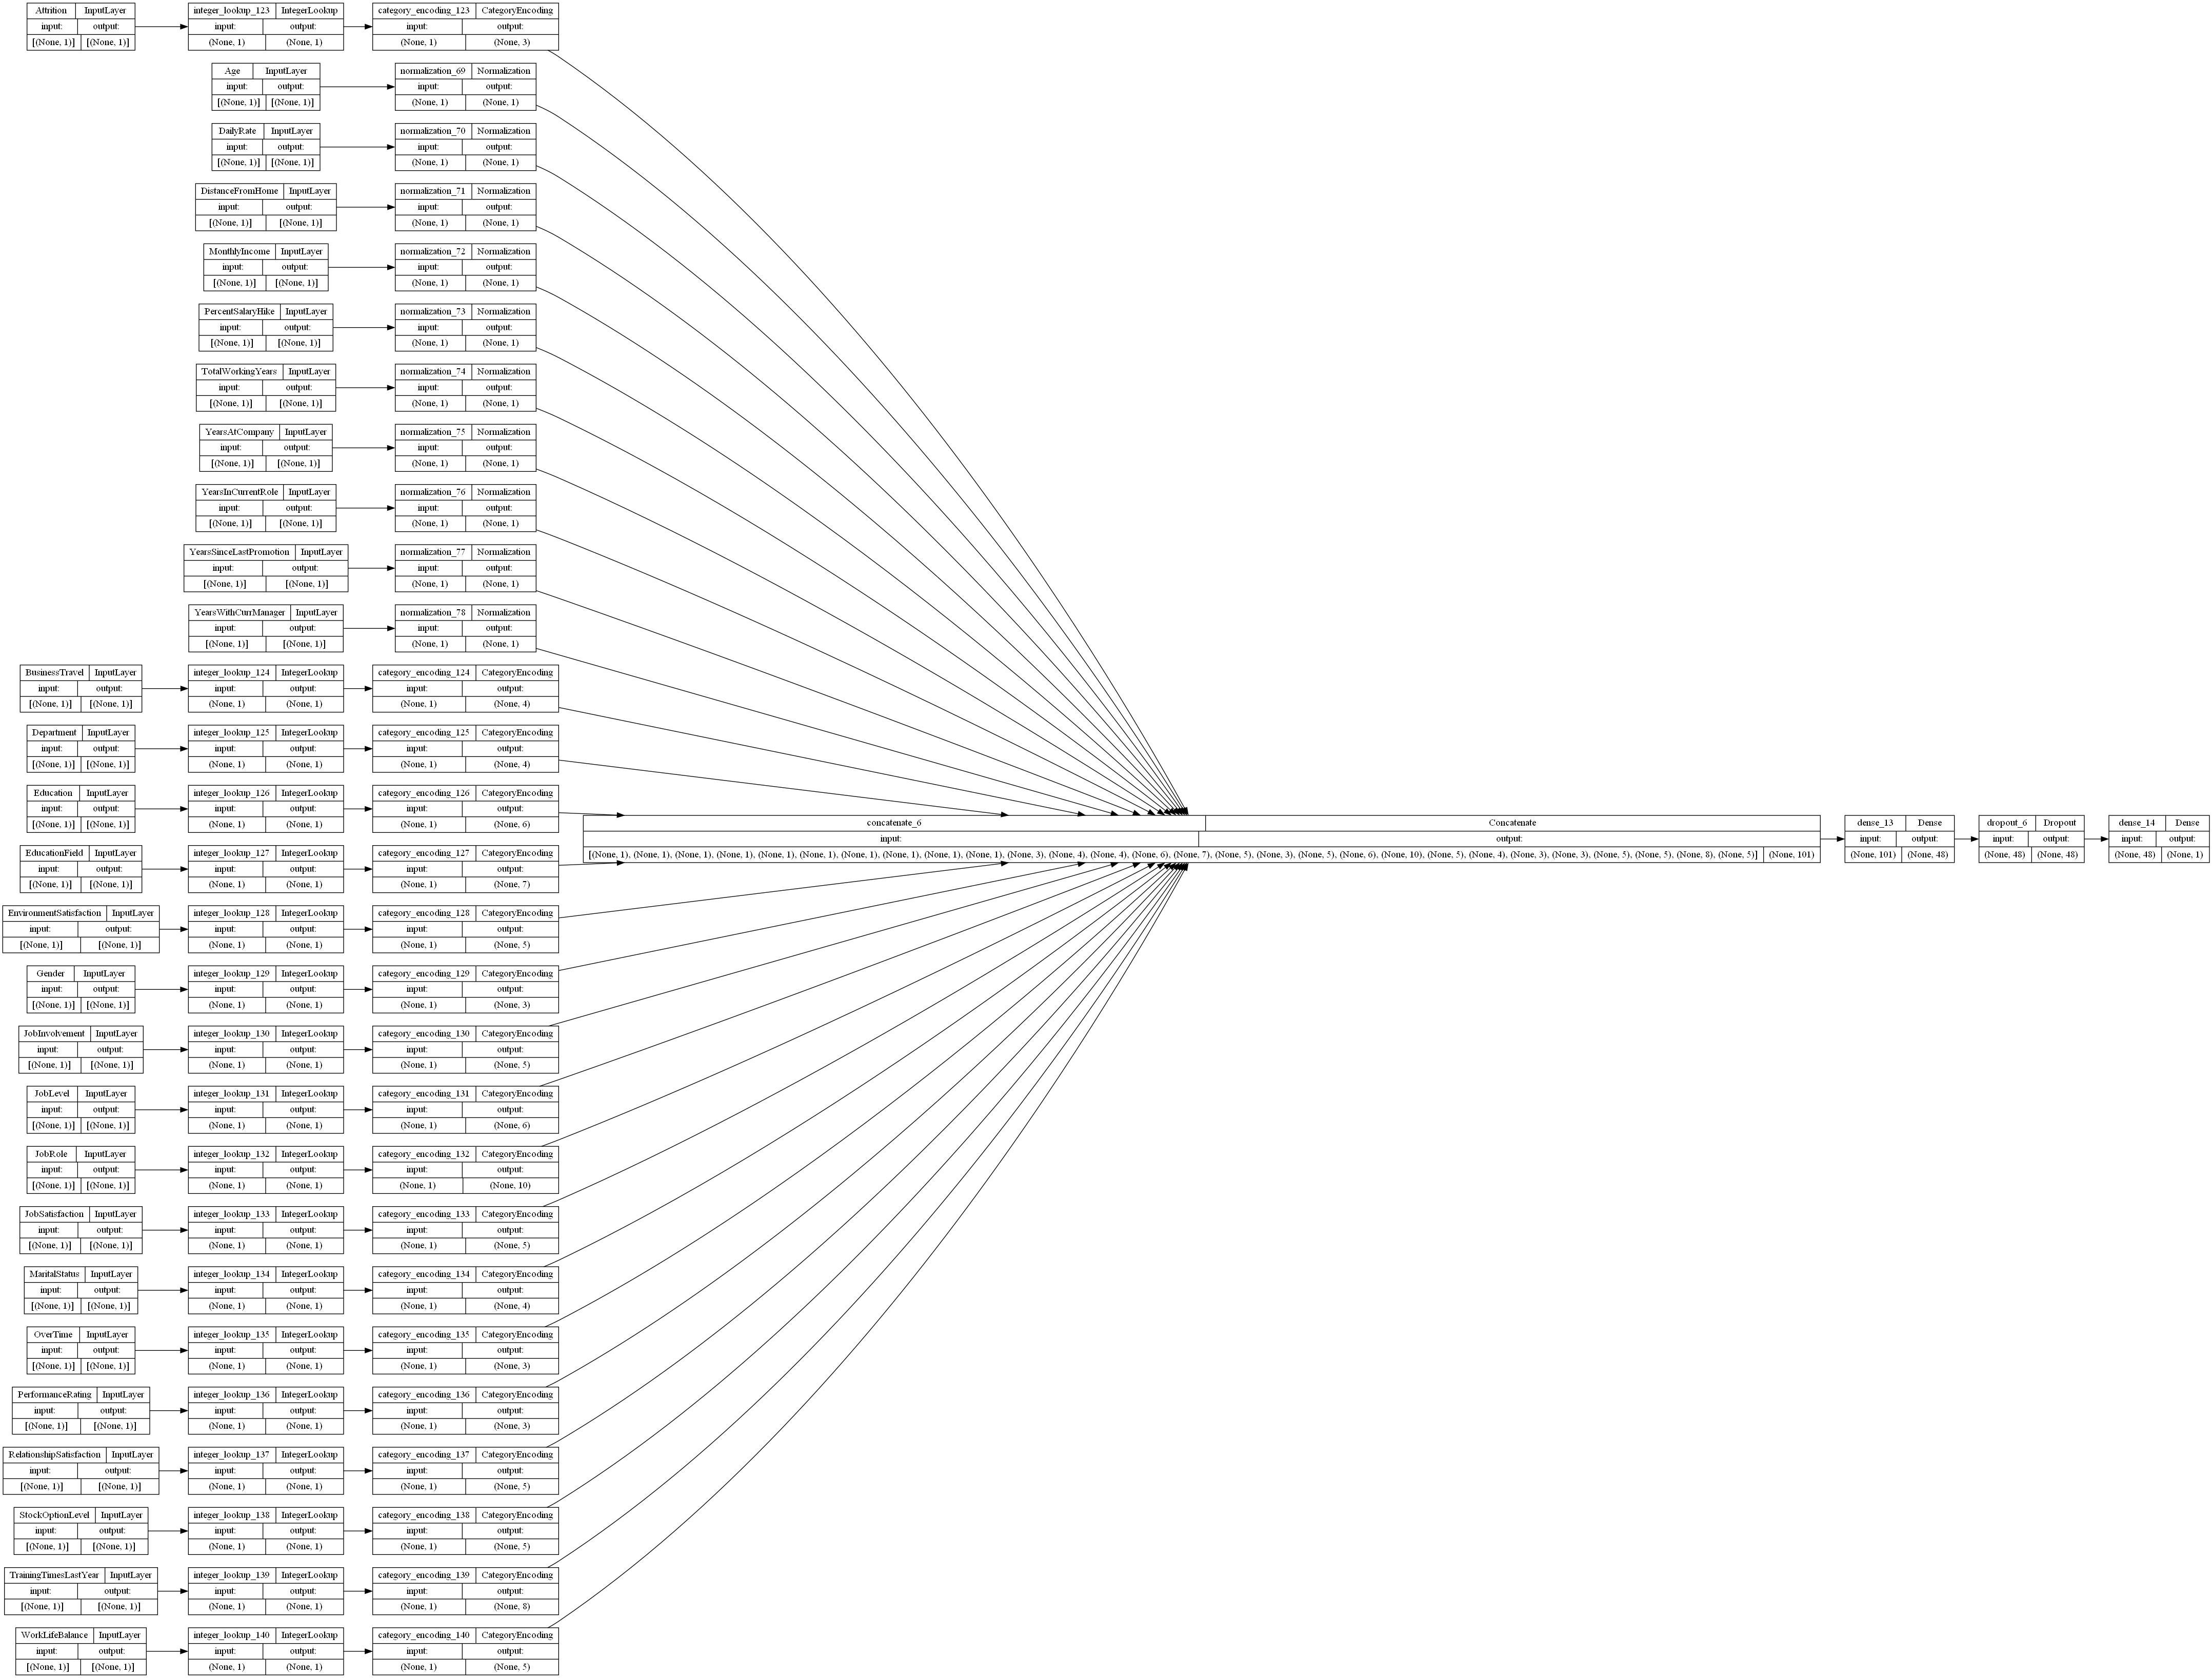

In [115]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [116]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


c:\Users\siman\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py:638: UserWarning: Input dict contained keys ['Unnamed: 0', 'HourlyRate', 'MonthlyRate', 'NumCompaniesWorked'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


2/2 [==============================] - 2s 680ms/step - loss: -1.4734 - accuracy: 0.1624 - val_loss: -1.6527 - val_accuracy: 0.1429
Epoch 2/10
2/2 [==============================] - 0s 25ms/step - loss: -1.5635 - accuracy: 0.1497 - val_loss: -1.6760 - val_accuracy: 0.1429
Epoch 3/10
2/2 [==============================] - 0s 28ms/step - loss: -1.5463 - accuracy: 0.1522 - val_loss: -1.6991 - val_accuracy: 0.1429
Epoch 4/10
2/2 [==============================] - 0s 29ms/step - loss: -1.5451 - accuracy: 0.1565 - val_loss: -1.7222 - val_accuracy: 0.1429
Epoch 5/10
2/2 [==============================] - 0s 21ms/step - loss: -1.5965 - accuracy: 0.1539 - val_loss: -1.7452 - val_accuracy: 0.1429
Epoch 6/10
2/2 [==============================] - 0s 28ms/step - loss: -1.6196 - accuracy: 0.1599 - val_loss: -1.7682 - val_accuracy: 0.1429
Epoch 7/10
2/2 [==============================] - 0s 35ms/step - loss: -1.6785 - accuracy: 0.1650 - val_loss: -1.7912 - val_accuracy: 0.1429
Epoch 8/10
2/2 [=======

In [117]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

1/1 [==============================] - 0s 23ms/step - loss: -1.8514 - accuracy: 0.2517
Accuracy 0.25170066952705383


In [118]:
model.save('job_satisfaction_classifier')

INFO:tensorflow:Assets written to: job_satisfaction_classifier\assets


INFO:tensorflow:Assets written to: job_satisfaction_classifier\assets
